This file trains and compares simple models from scikit-learn.<br>
Given the number of molecules in the dataset, they are likely to perform better than neural networks would.

<p>
The task is to distinguish if a molecule has a pIC50>8 or not. Therefore, we are interested in binary classifiers, like SVM, random forest, and naive bayes methods.

<p>Loss for them is typicaly measured with cross entropy, while their validation is often scored on accuracy, recall and derrived measures (F1), as well as the area under the ROC curve. In the case of a heavily biased dataset, like this one, accuracy can be misleading, so let us rely on <b>F1</b> (harmonic mean of recal and and precission) and <b>AUC</b> (area under the ROC).

# Load the libraries

In [1]:
import pickle
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from tqdm import tqdm, trange

from CustomMolDataset import CustomMolDataset, dataBlocks

# Load the data

In [2]:
# molecules
with open("molecules_3D.pickle", 'rb') as f:
    ligs = pickle.load(f)
    
# feature filters
with open("X_filt_w3D.pickle", 'rb') as f:
    X_filt_w3D=pickle.load(f)
with open("X_filt_no3D.pickle", 'rb') as f:
    X_filt_no3D=pickle.load(f)


# CustomMolDatasets
DescriptorBlocknames_no3D = ["MACCS", "rdkitFP", "MorganFP2", "MorganFP3",
                             "Descriptors", "EState_FP", "Graph_desc",
                             "MOE", "MQN", "AUTOCORR2D", "PEOE_VSA",
                             "SMR_VSA", "SlogP_VSA"]
DescriptorBlocknames_w3D = DescriptorBlocknames_no3D + [
                             "AUTOCORR3D", "WHIM", "RDF",
                             "USR", "USRCUT", "MORSE"]
flags_no3D = [int(dataBlocks(i).name in DescriptorBlocknames_no3D) for i in range(len(dataBlocks))]
flags_w3D = [int(dataBlocks(i).name in DescriptorBlocknames_w3D) for i in range(len(dataBlocks))]

DB_no3D = CustomMolDataset(ligs,
                  representation_flags = flags_no3D,
                  X_filter=X_filt_no3D,  # feature filter
                  normalize_x = True,   # now we normalize the features
                  use_hdf5_cache = "read-only", # read cache from file
                  name = "EGFR_set_all_features"
                 )
DB_no3D.find_normalization_factors() # will also build a faster in-memory cache
DB_no3D.cache_fp.close() # close the file handle so next dataset can also access it


DB_w3D = CustomMolDataset(ligs,
                  representation_flags = flags_w3D,
                  X_filter=X_filt_w3D, # feature filter
                  normalize_x = True,   # now we normalize the features
                  use_hdf5_cache = "read-only", # read cache from file
                  name = "EGFR_set_all_features"
                 )
DB_no3D.find_normalization_factors()
DB_no3D.cache_fp.close()

In [87]:
# function to convert pIC50 values provided by CustomMolDataset to one-hot arrays identifying classes (active/inactive)
# This is more usefull for NNs
def pIC50ToOneHot(y):
    mask=y>8
    return(np.hstack((np.logical_not(mask), mask)).astype(float))

# similar function to produce class numbers
# this is for simple models in this file
def pIC50ToClassID(y):
    mask=y>8
    return(np.hstack((mask)).astype(int))

# Train/Validation and cross-validation splits
Some models have meta-parameters that need tuning. This should not be done on the validation set, so we will do this tuning on cross-validation splits within the training set.

In [88]:
from sklearn.model_selection import KFold, train_test_split

# settings
split_seed = 123450
test_frac = 0.2
xval_folds = 5

# split the 2D only features
(
    no3D_train_x,
    no3D_test_x,
    no3D_train_y,
    no3D_test_y,
) = train_test_split(DB_no3D.internal_filtered_cache[0],
                     pIC50ToClassID(DB_no3D.internal_filtered_cache[1]),
                     test_size=test_frac, random_state=split_seed)

# split the 2D+3D features
(
    w3D_train_x,
    w3D_test_x,
    w3D_train_y,
    w3D_test_y,
) = train_test_split(DB_no3D.internal_filtered_cache[0],
                     pIC50ToClassID(DB_no3D.internal_filtered_cache[1]),
                     test_size=test_frac, random_state=split_seed)

# cross-validation
kf = KFold(n_splits=xval_folds, shuffle=True, random_state=split_seed+1978727) # shift seed by a prime

# Weigh classes examples by the number of samples in them
To help deal with unballanced dataset.

In [89]:
from sklearn.utils import class_weight

no3D_train_w = class_weight.compute_sample_weight("balanced", no3D_train_y)
no3D_test_w = class_weight.compute_sample_weight("balanced", no3D_test_y)

w3D_train_w = class_weight.compute_sample_weight("balanced", w3D_train_y)
w3D_test_w = class_weight.compute_sample_weight("balanced", w3D_test_y)

# Set up a lists of models and their performances

In [114]:
models={}
model_AUCs={}
model_F1s={}
model_ROCs_TPR={}
model_ROCs_FPR={}
model_run_time={}

# Functions that summarize classifier performance

In [140]:
from sklearn import metrics
import time

# evaluate model performance
def evaluate(name, classifier, dataX, dataY, weights=None, draw=False, save=True, verbose=True):
    start = time.time()
    predY = classifier.predict(dataX)
    duration=time.time()-start
    
    # ROC (weights don't matter)
    fpr, tpr, thresholds = metrics.roc_curve(
                                    dataY, predY,
                                    sample_weight=weights,
                                    pos_label=1       # actives are in class 1
                                    )
    AUC = metrics.auc(fpr, tpr)
    
    
    # F1 (weights don't matter in 'binary' averaging)
    pre, rec, F1, _ = metrics.precision_recall_fscore_support(
                                    dataY, predY,
                                    sample_weight=weights,
                                    pos_label=1,       # actives are in class 1
                                    average='binary'   
                                    )

    # report results
    if(verbose):
        print(f"AUC: {AUC:.3}\tF1: {F1:.3}, prec:{pre:.3}, recal:{rec:.3}")
    
    if(draw):
        plt.axis("square")
        plt.plot([0, 1], [0, 1], "k--", label="chance AUC=0.5")
        plt.plot(fpr,tpr, label=f"{name} AUC={AUC:.3}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC")
        plt.xlim((0,1))
        plt.ylim((0,1))
        plt.legend()
        plt.show()
    
    # write results into performance tracking dicts
    models[name] = classifier
    model_AUCs[name] = AUC
    model_F1s[name] = F1
    model_ROCs_TPR[name] = tpr
    model_ROCs_FPR[name] = fpr
    model_run_time[name] = duration
    
    # save the data to HDD for recovery in case of crash
    if(save):
        with open("simple_models_metrics.pickle", 'wb') as f:
            pickle.dump((models, model_AUCs, model_F1s,
                         model_ROCs_TPR, model_ROCs_FPR,
                         model_run_time),
                        f)

# Train SVMs
While searching for best regularization parameter C.
## Linear SVM classifier

Best parameters: {'C': 1.0}
AUC: 0.767	F1: 0.733, prec:0.857, recal:0.64


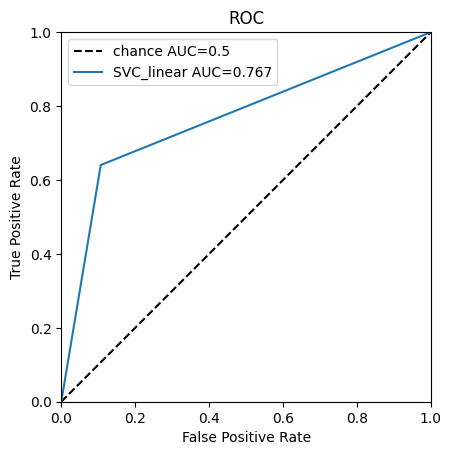

In [120]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# do a hyper-parameter search
param_grid = {'C': [0.025, 0.1, 0.5, 1.0, 2.0]}
base_estimator = SVC(kernel="linear", random_state=42, class_weight="balanced")

sh = GridSearchCV(base_estimator, param_grid,
                  scoring='f1',
                  cv=xval_folds, # cross validation folds
                  n_jobs=-1,     # use all processors
                  refit=True,    # fit best parameters on all data 
                 ).fit(no3D_train_x, no3D_train_y)

print("Best parameters:", sh.best_params_)
evaluate("SVC_linear", sh.best_estimator_, no3D_test_x, no3D_test_y, draw=True, weights=no3D_test_w)

## radial-basis function SVM classifier

Best parameters: {'C': 2.0}
AUC: 0.804	F1: 0.783, prec:0.876, recal:0.708


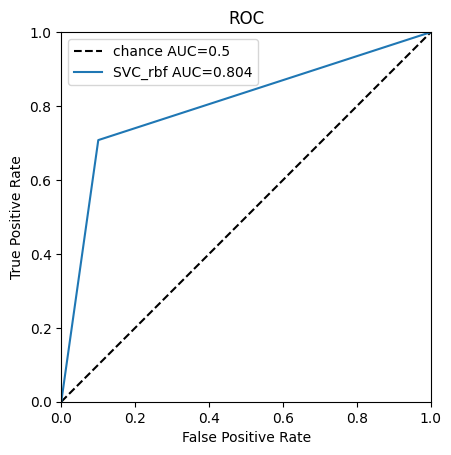

In [121]:
# do a hyper-parameter search
param_grid = {'C': [0.025, 0.1, 0.5, 1.0, 2.0]}
base_estimator = SVC(kernel="rbf", random_state=42, class_weight="balanced")

sh = GridSearchCV(base_estimator, param_grid,
                  scoring='f1',
                  cv=xval_folds, # cross validation folds
                  n_jobs=-1,     # use all processors
                  refit=True,    # fit best parameters on all data 
                 ).fit(no3D_train_x, no3D_train_y)

print("Best parameters:", sh.best_params_)
evaluate("SVC_rbf", sh.best_estimator_, no3D_test_x, no3D_test_y, draw=True, weights=no3D_test_w)

# Random Forest

# Compare best models of each type so far

In [141]:
# re-evaluate the models, if needed
for key in tqdm(models.keys()):
    evaluate(key, models[key], no3D_test_x, no3D_test_y, weights=no3D_test_w, draw=False, save=True, verbose=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.15s/it]


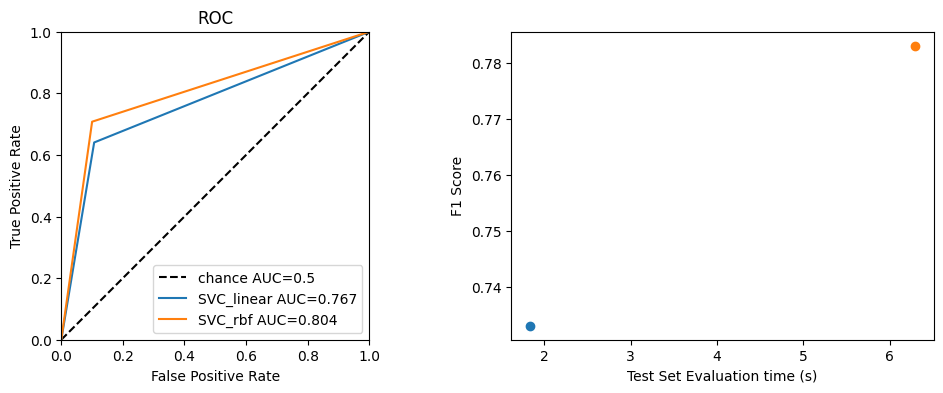

In [142]:
plt.figure(figsize=(12,4))

# ROC
plt.subplot(1,2,1)
plt.axis("square")
plt.plot([0, 1], [0, 1], "k--", label="chance AUC=0.5")
# loop through all saved models
for key in models.keys():
    plt.plot(model_ROCs_FPR[key],
             model_ROCs_TPR[key],
             label=f"{key} AUC={model_AUCs[key]:.3}")
    
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC")
plt.xlim((0,1))
plt.ylim((0,1))
plt.legend()

# F1 vs execution time
plt.subplot(1,2,2)
for key in models.keys():
    plt.scatter([model_run_time[key]], [model_F1s[key]], label=key)
plt.xlabel("Test Set Evaluation time (s)")
plt.ylabel("F1 Score")

plt.show()